<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to show how we can use GPs to handle real-world problems beyond simple classification and regression settings.

In particular, we will focus on following scenarios:

- Handling temporal/sequential dependencies
- Working with spatial data
- Building models for multiple outputs
- Dealing with heteroscedastic noise
- Handling input uncertainty
- Making GPs interpretable via ARD and additive models

## Working with temporal data

We will discuss two types of modeling problems. One, in which we are interested in forecasting (one-step ahead or multi-step ahead), and two, in which we are interested in building a classification or regression model, but the input data has temporal dependencies.

### Scenario 1 - Time series forecasting
Let us first generate a very simple data set.

In [377]:
%run Utilities.ipynb

In [378]:
# Number of samples. 
n = 1000
# Generate "time" variable. 
t = np.arange(n)
data_df = pd.DataFrame({'t' : t})

In [379]:
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    return y1

In [381]:
# Add one seasonal components. 
data_df['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=40))

# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Define target variable. 
data_df['y1'] = data_df['s1']
# Add noise to target variable. 
data_df ['y1'] = data_df ['y1'] + data_df ['epsilon']



In [382]:
# define our kernel
kernel = GPy.kern.StdPeriodic(1,variance=0.1,lengthscale=1,period=40)
#kernel = GPy.kern.RBF(1,variance=0.1,lengthscale=1)

In [383]:
X = data_df['t'].values.reshape(n, 1)
y = data_df['y1'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

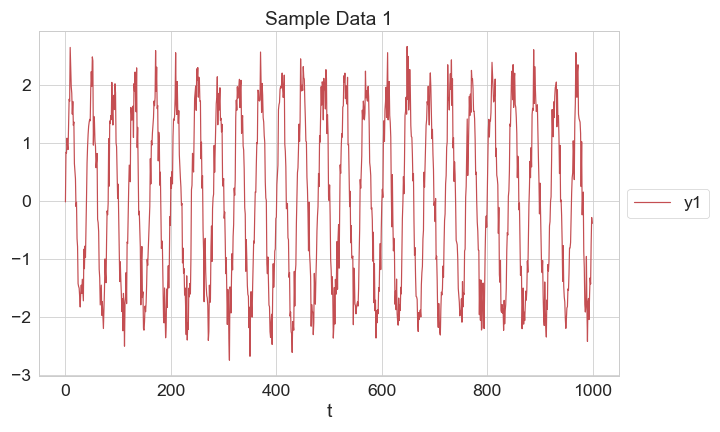

In [384]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='t', y='y1', data=data_df, color='r', label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 1', xlabel='t', ylabel='');
plt.tight_layout()

In [385]:
# sample from prior
means = np.zeros(X_train.shape) # assuming a zero mean-function
covmat = kernel.K(X_train)
# Draw few samples from the prior
samples = np.random.multivariate_normal(means.ravel(),covmat, 10).T

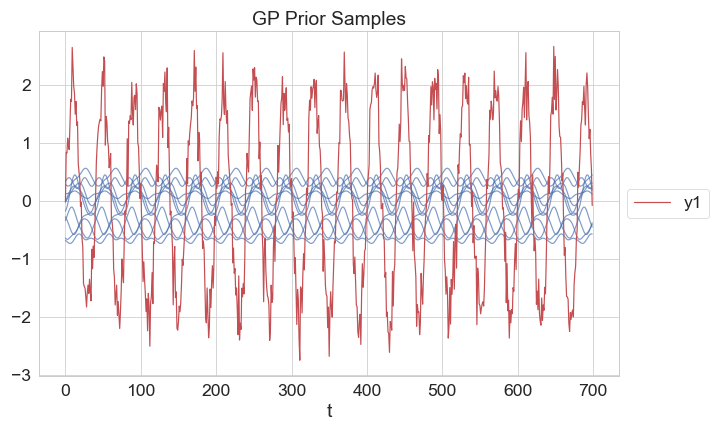

In [386]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(samples.shape[1]):
    sns.lineplot(x=X_train[...,0], y = samples[:, i], color='b', alpha=0.7, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color='r', label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP Prior Samples', xlabel='t');
plt.tight_layout()

In [387]:
# fit a model
md = GPy.models.GPRegression(X_train,y_train,kernel=kernel,noise_var=1e-3)

In [388]:
md.optimize()

In [389]:
print(md)


Name : GP regression
Objective : 187.09818702274623
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                value  |  constraints  |  priors
  std_periodic.variance     |   10.211055404239852  |      +ve      |        
  std_periodic.period       |    39.99944394184238  |      +ve      |        
  std_periodic.lengthscale  |    1.610582945272313  |      +ve      |        
  Gaussian_noise.variance   |  0.09467304881194043  |      +ve      |        


In [390]:
y_pred,y_std = md.predict(X)
data_df['y_pred'] = y_pred
data_df['y_std'] = np.sqrt(y_std)
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

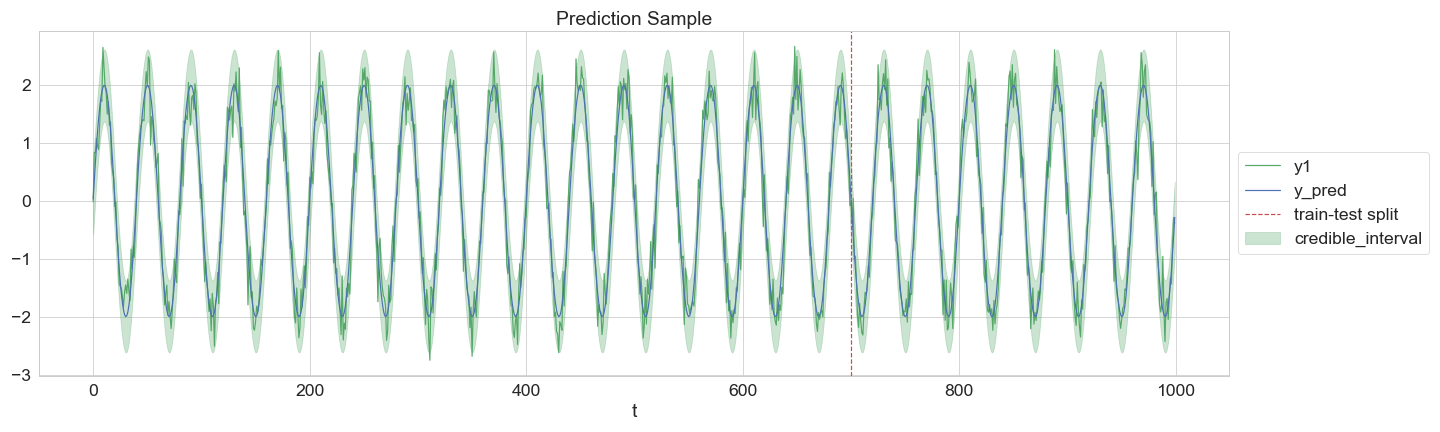

In [391]:
fig, ax = plt.subplots(figsize=(20,6))

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='g', 
    alpha=0.3, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y1', data=data_df, color='g', label = 'y1', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color='b', label='y_pred', ax=ax)

ax.axvline(n_train, color='r', linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample', xlabel='t', ylabel='')
plt.tight_layout()

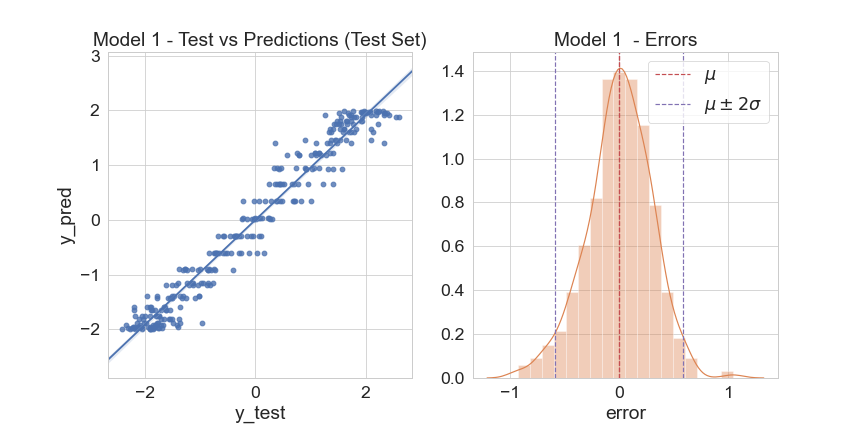

In [392]:
errors = md.predict(X_test)[0] - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=md.predict(X_test)[0].flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 1 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 1  - Errors', xlabel='error', ylabel=None);

Clearly GPR does a fairly accurate job in forecasting the values. The secret ingredient of course is the right kernel. You can verify that if you use a different kernel (e.g., `RBF` or `Matern32`) you might not be able to replicate the same results.

#### Time series with more structure
Next we will study more challenging problems:
- linear trend
- linear trend + second seasonal component
- non-linear trend + two seasonal components

In [395]:
# Generate trend component. 
def linear_trend(beta, x):
    """Scale vector by a scalar."""
    trend_comp = beta * x 
    return trend_comp

data_df['tr1'] = data_df['t'].apply(lambda x : linear_trend(0.01, x))

# Add trend to target variable y_1. 
data_df['y2'] = data_df['y1'] + data_df['tr1']

# Create other seasonal component.
data_df['s2'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=1, period=13.3))
# Add to y_2.
data_df['y3'] = data_df['y2'] + data_df['s2'] 

# Generate trend component. 
def non_linear_trend(x):
    """Scale and take square root."""
    trend_comp = 0.75 * np.power(x, 1/2)
    return trend_comp

# Compute non-linear trend. 
data_df ['tr2'] = data_df['t'].apply(non_linear_trend)

# Add trend to target variable. 
data_df ['y4'] = data_df ['y3'] + data_df ['tr2']


In [396]:
data_df.head()

,t,s1,epsilon,y1,y_pred,y_std,y_pred_lwr,y_pred_upr,tr1,y2,s2,y3,tr2,y4
0,0,0.000000,-0.021052,-0.021052,0.027672,0.309028,-0.590385,0.645728,0.00,-0.021052,0.000000,-0.021052,0.000000,-0.021052
1,1,0.312869,0.519508,0.832377,0.343608,0.309017,-0.274427,0.961643,0.01,0.842377,0.455043,1.297420,0.750000,2.047420
2,2,0.618034,0.203674,0.821708,0.645863,0.309009,0.027845,1.263882,0.02,0.841708,0.810403,1.652111,1.060660,2.712771
3,3,0.907981,0.168381,1.076362,0.927389,0.309004,0.309381,1.545398,0.03,1.106362,0.988236,2.094598,1.299038,3.393637
4,4,1.175571,-0.239579,0.935992,1.182671,0.309002,0.564668,1.800675,0.04,0.975992,0.949586,1.925578,1.500000,3.425578


In [416]:
ylabel = 'y4'

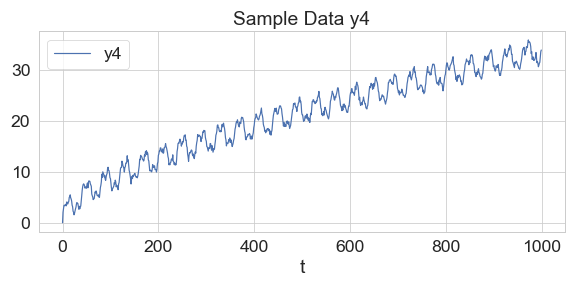

In [417]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(x='t', y=ylabel, data=data_df, color=sns_c[0], label=ylabel, ax=ax)
ax.set(title='Sample Data {}'.format(ylabel), xlabel='t', ylabel='')

errors = md.predict(X_test)[0] - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()
plt.tight_layout()

In [199]:
gp4.kernel_

WhiteKernel(noise_level=0.01) + 5.3**2 * ExpSineSquared(length_scale=30.4, periodicity=40) + 6.02**2 * RationalQuadratic(alpha=1, length_scale=508) + 3.2**2 * ExpSineSquared(length_scale=33, periodicity=13.3)

In [420]:
# define our kernel
kernel1 = GPy.kern.StdPeriodic(1,variance=5.3**2,lengthscale=30.4,period=40)
kernel2 = GPy.kern.RBF(1,variance=1,lengthscale=100)
kernel2 = GPy.kern.RatQuad(1,variance=6.02**2,lengthscale=508,power=1)
#kernel3 = GPy.kern.StdPeriodic(1,variance=3.2**2,lengthscale=33,period=13.3)

kernel = kernel1 + kernel2 + kernel3


X = data_df['t'].values.reshape(n, 1)
y = data_df[ylabel].values.reshape(n, 1)
prop_train = 0.7
n_train = round(prop_train * n)
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]
# fit a model
md = GPy.models.GPRegression(X_train,y_train,kernel=kernel,noise_var=0.01)
#md.optimize()
# get predictions on the test data
y_pred,y_std = md.predict(X)
data_df['y_pred'] = y_pred
data_df['y_std'] = np.sqrt(y_std)
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

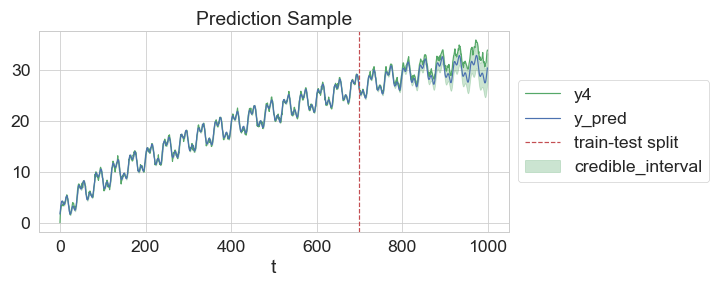

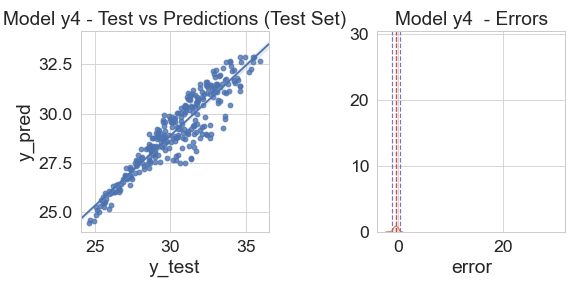

In [421]:
fig, ax = plt.subplots(figsize=(10,4))

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='g', 
    alpha=0.3, 
    label='credible_interval'
)

sns.lineplot(x='t', y=ylabel, data=data_df, color='g', label = ylabel, ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color='b', label='y_pred', ax=ax)

ax.axvline(n_train, color='r', linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample', xlabel='t', ylabel='')
plt.tight_layout()
fig, ax = plt.subplots(1, 2, figsize=(8, 4)) 
sns.regplot(x=y_test.flatten(), y=md.predict(X_test)[0].flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[0].set(title='Model {} - Test vs Predictions (Test Set)'.format(ylabel), xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model {}  - Errors'.format(ylabel), xlabel='error', ylabel=None);
plt.tight_layout()

### Scenario 2 -  Data with temporal structure

For the second scenario, we are given a traditional ML data set, with inputs ($X$) and outputs ($y$). However, the observations have an associated time stamp. We want to exploit the temporal relationship present in the data to our advantage.

Let us first load the data. We have two data sets in the repository with slightly different properties - `synthetic_disease_data1.csv` and `synthetic_disease_data2.csv`.

In [436]:
data_ts1 = pd.read_csv('synthetic_disease_data2.csv',
                       index_col=0,parse_dates=True)

In [437]:
data_ts1.head()

,Feature 1,Feature 2,Feature 3,Num Cases
Time,,,,
2017-09-03,0.23,-0.68,-0.33,-2.111536
2017-09-05,0.08,1.19,3.10,0.348763
2017-09-07,0.01,-0.64,-0.25,-1.928960
2017-09-11,1.77,-0.46,-0.56,-0.687608
2017-09-12,-0.05,-0.10,1.00,1.009577


There are three input features and one target `Num Cases`. Each example also has a time stamp. Note that the data does not appear to be uniformly sampled in time.

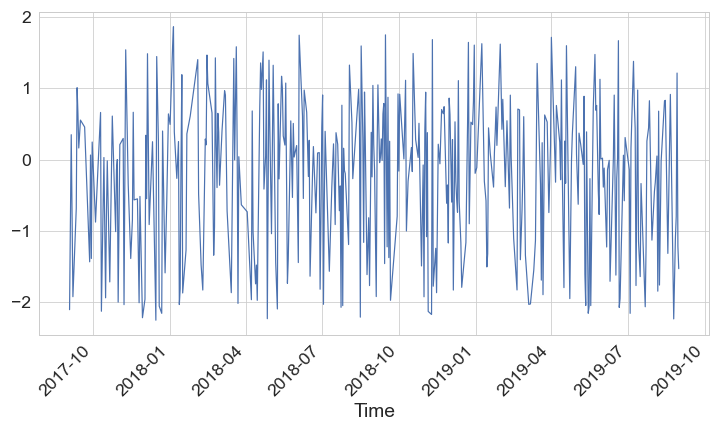

In [438]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
data_ts1['Num Cases'].plot(ax=ax)
plt.xticks(rotation=45)
plt.tight_layout()

We first build a model that ignores the time aspect

In [439]:
# prepare training and testing data
X = data_ts1[['Feature 1','Feature 2','Feature 3']].values
y = data_ts1['Num Cases'].values
prop_train = 0.7
n_train = round(prop_train * len(y))

X_train = X[:n_train]
y_train = y[:n_train][:,np.newaxis]

X_test = X[n_train:]
y_test = y[n_train:][:,np.newaxis]

In [440]:
kernel = GPy.kern.RBF(3,variance=1,lengthscale=1)
md = GPy.models.GPRegression(X_train,y_train,kernel=kernel,noise_var=0.1)
md.optimize()
# get predictions on the test data
y_pred,y_std = md.predict(X_test)

RMSE = 0.05


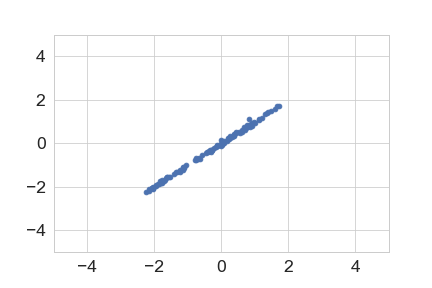

In [441]:
# evaluate the predictions
plt.scatter(y_test,y_pred)
plt.ylim([-5,5])
plt.xlim([-5,5])
print('RMSE = {:.2f}'.format(np.sqrt(np.mean((y_test - y_pred)**2))))

Does not look very good. Now let us try to "exploit" the temporal effect. We will first add a new "feature" that indicates the time. Then, we will prepare a kernel that is an addition of two kernels, one that works on the covariates and the other that works on time.

In [442]:
data_ts1['timeindex'] = (data_ts1.index - data_ts1.index.min()).days

In [443]:
data_ts1.head()

,Feature 1,Feature 2,Feature 3,Num Cases,timeindex
Time,,,,,
2017-09-03,0.23,-0.68,-0.33,-2.111536,0
2017-09-05,0.08,1.19,3.10,0.348763,2
2017-09-07,0.01,-0.64,-0.25,-1.928960,4
2017-09-11,1.77,-0.46,-0.56,-0.687608,8
2017-09-12,-0.05,-0.10,1.00,1.009577,9


In [444]:
# prepare training and testing data
X = data_ts1[['Feature 1','Feature 2','Feature 3','timeindex']].values
y = data_ts1['Num Cases'].values
prop_train = 0.7
n_train = round(prop_train * len(y))

X_train = X[:n_train]
y_train = y[:n_train][:,np.newaxis]

X_test = X[n_train:]
y_test = y[n_train:][:,np.newaxis]

In [445]:
kernel1 = GPy.kern.StdPeriodic(1,variance=1,lengthscale=1,period=30,active_dims=[3])
kernel2 = GPy.kern.RBF(3,variance=0.75,lengthscale=1,active_dims=[0,1,2])
kernel = kernel1 + kernel2 
#kernel = kernel2
md = GPy.models.GPRegression(X_train,y_train,kernel=kernel,noise_var=0.001)
md.optimize()
# get predictions on the test data
y_pred,y_std = md.predict(X_test)

RMSE = 0.05


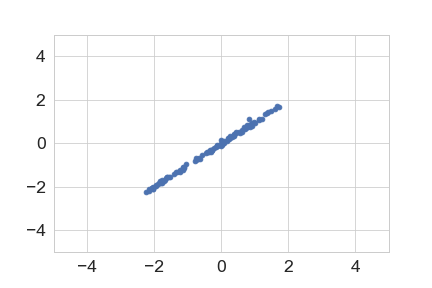

In [446]:
# evaluate the predictions
plt.scatter(y_test,y_pred)
plt.ylim([-5,5])
plt.xlim([-5,5])
print('RMSE = {:.2f}'.format(np.sqrt(np.mean((y_test - y_pred)**2))))

## Working with Spatial Data
Works in the same way as temporal data, but we need to apply a suitable kernel on the `x`,`y`locations